# TIME SERIES ANALYSIS ON W.H.O SUICIDE DATA
## PROBLEM DESCRIPTION
World Health Organization is an internaltional body involved in global health challenges and solutions.In one of its popular 

data analytics datasets, the number of deaths due to suicides in about 140 countries were highlighted. These suicide counts 

were grouped in  5 age ranges: 5-14 years ,15-24 years,25-34 years,35-54 years,55-74 years,75+ years-for different countries 

in diferent years and sexes. The entire population counts were also include against each group, as shown below in cell 2.

The main objective is to convert the dataset into a time series and use it to develop a model to forecast male population of 

country called Albania. The whole journey is presented in this Notebook.


#### Import tools

In [1]:
import pandas as pd
import numpy as np
import scipy as sc
import statsmodels
import patsy
import seaborn as sn
import matplotlib.pyplot as plt

#### Load dataset and view

In [2]:
data=pd.read_csv('who_suicide_statistics.csv')
data.head(6)

,country,year,sex,age,suicides_no,population
0,Albania,1985,female,15-24 years,NaN,277900.0
1,Albania,1985,female,25-34 years,NaN,246800.0
2,Albania,1985,female,35-54 years,NaN,267500.0
3,Albania,1985,female,5-14 years,NaN,298300.0
4,Albania,1985,female,55-74 years,NaN,138700.0
5,Albania,1985,female,75+ years,NaN,34200.0


#### View number of unique countries

In [3]:
data['country'].unique().shape

(141,)

#### Extraction of Albania male pop from dataset, set column 'year' as index and drop same

In [4]:
Albania_male_population=data.loc[(data['country']=='Albania') & (data['sex']=='male')]
Albania_male_population.index=Albania_male_population['year']
Albania_male_population.drop('year', axis=1).tail()

,country,sex,age,suicides_no,population
year,,,,,
2015,Albania,male,25-34 years,NaN,222680.0
2015,Albania,male,35-54 years,NaN,374464.0
2015,Albania,male,5-14 years,NaN,184114.0
2015,Albania,male,55-74 years,NaN,287770.0
2015,Albania,male,75+ years,NaN,64200.0


#### Check for missing values in the dataset

In [5]:
Albania_male_population.isnull().sum()

country         0
year            0
sex             0
age             0
suicides_no    54
population      0
dtype: int64

#### Check statistical information

In [6]:
Albania_male_population['population'].describe()

count       186.000000
mean     233970.779570
std      111453.988114
min       21100.000000
25%      177639.250000
50%      244950.000000
75%      319000.000000
max      391767.000000
Name: population, dtype: float64

#### Aggregate dataset into time series and name it pop_by_year

In [7]:
pop_by_year=Albania_male_population.groupby(by=Albania_male_population.index)['population'].aggregate([np.sum])
pop_by_year.columns=['yearly_male_population']
pop_by_year.tail()

,yearly_male_population
year,
2011,1362894.0
2012,1364391.0
2013,1368205.0
2014,1371502.0
2015,1374005.0


#### Check unique years

In [8]:
len(pop_by_year.index.unique())

31

#### Check for outliers using the boxplot

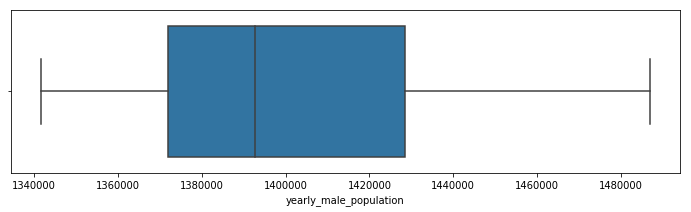

In [9]:
plt.figure(figsize=(12,3))
sn.boxplot(pop_by_year['yearly_male_population'])
plt.show()

#### plot time series of data at global level

Text(0.5, 1.0, 'Yearly Male population')

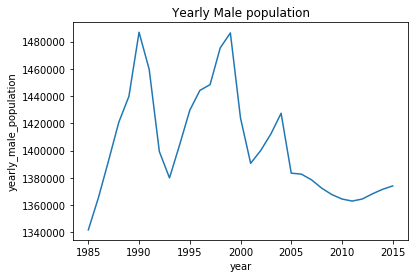

In [10]:
f,ax=plt.subplots(sharex=True)
f.set_size=(20,5)
sn.lineplot(pop_by_year.index,pop_by_year['yearly_male_population'])
ax.set_title('Yearly Male population')

#### lower granular plot

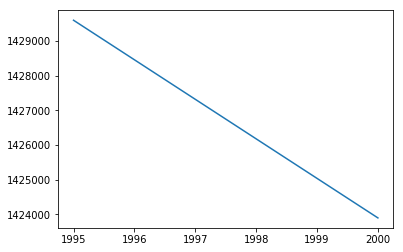

In [11]:
plt.plot(pop_by_year['yearly_male_population'].loc[(pop_by_year.index==1995)|(pop_by_year.index==2000)],label='Yearly population')
plt.show()

Lower granular plot shows decay trend in data

#### plots of autocorrelation and partial autocorrelation to check presence of seasonality, trend and even cyclical variations

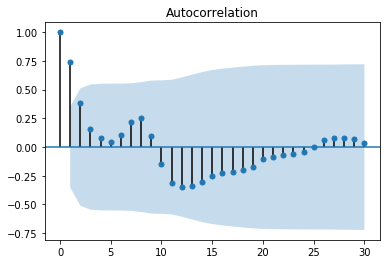

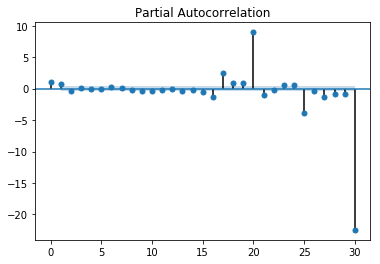

In [12]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
plot_acf(pop_by_year['yearly_male_population'])
plot_pacf(pop_by_year['yearly_male_population'])
plt.show()

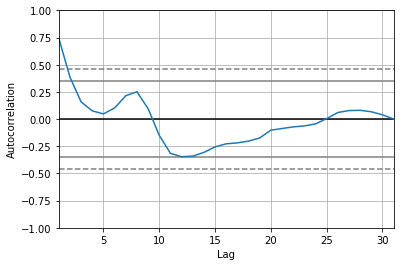

In [13]:
#statsmodels.graphics.tsaplots.plot_acf(pop_by_year['yearly_male_death'])
ffig1=pd.plotting.autocorrelation_plot(pop_by_year['yearly_male_population'])

##### Ljung Box test for stationarity (randomness) @95% confidence level

In [14]:
_,_,_,pv=statsmodels.tsa.stattools.acf(pop_by_year['yearly_male_population'],unbiased=True,nlags=3,qstat=True, alpha=0.05)
print('Null hypothesis is rejected for lags:',np.where(pv<=0.05))

Null hypothesis is rejected for lags: (array([0, 1, 2], dtype=int32),)


#### ADF Test on data for correlation

In [15]:
#ADF Test on data
pv=statsmodels.tsa.stattools.adfuller(pop_by_year['yearly_male_population'],autolag='AIC',)
pv[1]

0.7142097865911644

#### confirmation of non-stationarity in data using qqplot

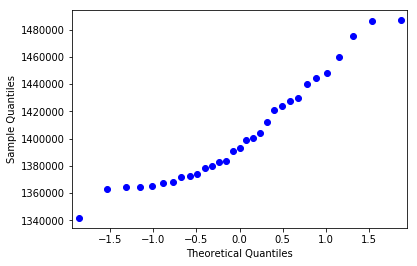

In [16]:
import statsmodels.api as sm
ff=sm.qqplot(pop_by_year['yearly_male_population'])

**The qqplot shows data is not stationary

#### checking level of differencing to correct non-stationarity

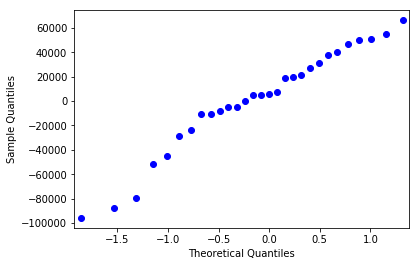

In [17]:
ff=sm.qqplot(pop_by_year['yearly_male_population'].diff(2))

After manual trials the data attains rough randomness with second degree differencing(seansonality removal) as shown in qqplot above

### After gaining information about the inherent structure of data, we can now develop forecast model with ARIMA aiming to minimize Alkaike Information Criterion in optimization¶

In [18]:
import statsmodels.tsa.api as smtsa
AICMin=[]
for d in range(0,3):
    for ari in range(0, 2):
        for maj in range(0,3):
            try:
                arima_obj = smtsa.ARIMA(pop_by_year['yearly_male_population'].tolist(),order=(ari,d,maj))
                arima_obj_fit=arima_obj.fit()
                AICMin.append([ari, d, maj, arima_obj_fit.aic])
            except ValueError:
                pass


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


View results of model optimization process

In [19]:
results=pd.DataFrame(AICMin,columns=['AR[p]','DIFF[h]','MA[q]','AIC_Score'])
results

,AR[p],DIFF[h],MA[q],AIC_Score
0,0,0,0,747.208233
1,0,0,1,724.092972
2,1,0,0,720.436806
3,1,0,1,714.514271
4,1,0,2,715.860623
5,0,1,0,697.527911
6,0,1,1,693.671278
7,0,1,2,695.468924
8,1,1,0,696.257138
9,0,2,0,683.627209


#### Evaluating fit using optimal parameter
Note: order(0,2,2) had least AIC score but did not perform well in forcast so 0,1,2 was adjudged best after trials

In [20]:
# Evaluating fit using optimal parameter
arima_obj =smtsa.ARIMA(pop_by_year['yearly_male_population'].tolist(), order=(0,1,2))
arima_obj_fit = arima_obj.fit(disp=0)
arima_obj_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                    D.y   No. Observations:                   30
Model:                 ARIMA(0, 1, 2)   Log Likelihood                -343.734
Method:                       css-mle   S.D. of innovations          22791.174
Date:                Mon, 15 Jul 2019   AIC                            695.469
Time:                        09:59:55   BIC                            701.074
Sample:                             1   HQIC                           697.262
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1076.8335   5442.678      0.198      0.845   -9590.620    1.17e+04
ma.L1.D.y      0.4250      0.224      1.896      0.069      -0.014       0.864
ma.L2.D.y     -0.1116      0.249     -0.449      0.657      -0.599       0.375
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
MA.1           -1.6437           +0.0000j            1.6437            0.5000
MA.2            5.4514           +0.0000j            5.4514            0.0000
-----------------------------------------------------------------------------
"""

In [21]:
pred = np.append([0],arima_obj_fit.fittedvalues.tolist())
pop_by_year['ARIMA']=pred
actualval=np.append([0], arima_obj_fit.resid+arima_obj_fit.fittedvalues)
pop_by_year['Actualval']=actualval

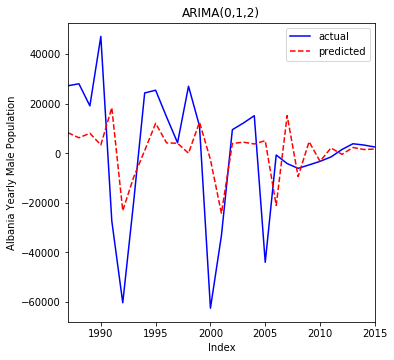

In [22]:
"""
The comparison with the actual and forecasted values is obtained and visualized using the
following script:
"""
# Plot the curves
f, axarr = plt.subplots(1, sharex=True)
f.set_size_inches(5.5, 5.5)
pop_by_year['Actualval'].iloc[2:].plot(color='b', linestyle = '-',label='actual',ax=axarr)
pop_by_year['ARIMA'].iloc[2:].plot(color='r', linestyle = '--',label='predicted', ax=axarr)
axarr.set_title('ARIMA(0,1,2)')
plt.xlabel('Index')
plt.ylabel('Albania Yearly Male Population')
plt.legend()

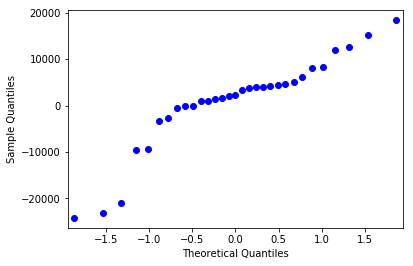

In [23]:
ff=sm.qqplot(pop_by_year['ARIMA'])

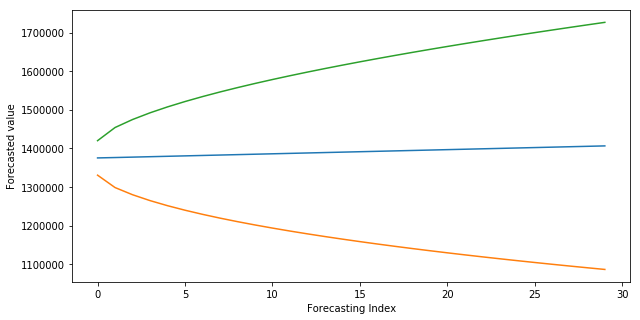

<Figure size 720x360 with 0 Axes>

In [24]:
# Forecasting and CI
plt.figure(figsize=(10,5))
f, err, ci=arima_obj_fit.forecast(30)
plt.plot(f)
plt.plot(ci)
plt.xlabel('Forecasting Index')
plt.ylabel('Forecasted value')
plt.figure(figsize=(10,5))
plt.show()

Let's check values of forecast population for the 30 years

In [25]:
Albania_male_Population_forecasts_for_30_years_from_2015=pd.DataFrame({'Forecast':f})

#view first ten years forcsts
Albania_male_Population_forecasts_for_30_years_from_2015.head(10)

,Forecast
0,1.375233e+06
1,1.376217e+06
2,1.377294e+06
3,1.378371e+06
4,1.379448e+06
5,1.380525e+06
6,1.381602e+06
7,1.382678e+06
8,1.383755e+06
9,1.384832e+06


Let's try SARIMAX model

In [26]:
mod = sm.tsa.statespace.SARIMAX(pop_by_year['yearly_male_population'], trend='n', order=(0,1,2),
seasonal_order=(1,1,1,5))
sarimax= mod.fit()
sarimax.summary()

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                
=========================================================================================
Dep. Variable:            yearly_male_population   No. Observations:                   31
Model:             SARIMAX(0, 1, 2)x(1, 1, 1, 5)   Log Likelihood                -294.412
Date:                           Mon, 15 Jul 2019   AIC                            598.824
Time:                                   09:59:58   BIC                            604.918
Sample:                                        0   HQIC                           600.514
                                            - 31                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.0429      0.094      0.456      0.649      -0.142       0.227
ma.L2          0.0629      0.106      0.596      0.551      -0.144       0.270
ar.S.L5        0.4068      0.933      0.436      0.663      -1.422       2.236
ma.S.L5       -0.3723      0.961     -0.387      0.698      -2.255       1.511
sigma2      7.838e+08   1.54e-09    5.1e+17      0.000    7.84e+08    7.84e+08
===================================================================================
Ljung-Box (Q):                       30.60   Jarque-Bera (JB):                 0.82
Prob(Q):                              0.17   Prob(JB):                         0.66
Heteroskedasticity (H):               0.28   Skew:                            -0.38
Prob(H) (two-sided):                  0.09   Kurtosis:                         3.44
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.46e+34. Standard errors may be unstable.
"""

In [27]:
# Forecasting and CI
f=sarimax.forecast(10)
#plt.plot(f)
#plt.plot(ci)
#plt.xlabel('Forecasting Index')
#plt.ylabel('Forecasted value')

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


SARIMAX Model is not reliable for the dataset though AIC score was further reduced.

__THANKS!!!__